 # Определение целевой аудитории фитнес-клуба
### Цель 
на основе алгоритмов машинного обучения сделать кластеризацию клиентов и разработать методы взаимодействия с ними.<br>
### Задачи:
1. описать поведение клиентов с разбивкой на ушедших и оставшихся и без - проведение исследовательского анализа данных;<br>
2. построить модель бинарной классификации клиентов методами бинарной классификации и случайный лес; оценить метрики accuracy, precision и recall для обеих моделей <br>
3. провести кластеризацию объектов<br>
4. сделать общие выводы и рекомендации по уменьшению % оттока.


In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage 

In [4]:
gym = pd.read_csv("/datasets/gym_churn.csv")

### 1. Анализ данных <br>

Изучим средние значения и стандартные отклонения методом describe(); разделим данные на две выборки - тех, кто ушел в отток и тех, кто остался, сравним их средние значения и постоим столбчатые гистограммы и матрицу корреляции признаков. 

In [5]:
gym.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [6]:
gym.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
Near_Location                        4000 non-null int64
Partner                              4000 non-null int64
Promo_friends                        4000 non-null int64
Phone                                4000 non-null int64
Contract_period                      4000 non-null int64
Group_visits                         4000 non-null int64
Age                                  4000 non-null int64
Avg_additional_charges_total         4000 non-null float64
Month_to_end_contract                4000 non-null float64
Lifetime                             4000 non-null int64
Avg_class_frequency_total            4000 non-null float64
Avg_class_frequency_current_month    4000 non-null float64
Churn                                4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 437.6 KB


In [7]:
gym.describe()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000



Данные за нас обработали: убрали пропуски, заменили категориальные переменные на количесвтенные и провели их стандартизацию. <br><h6>Из данных мы узнаем: </h6> - максимальная длительность абонемента - 12 месяцев,<br> - в среднем, на дополнительные услуги фитнес-центра тратят около 140 руб (возможная точка роста прибыли),<br> - половина пользователей покупает абонемент на месяц и половина пользователей задерживается в фитнес-центре на 3 месяца, <br> - в среднем, посещают зал 1.8 раз в неделю (скорее всего два, но иногла пропускают одно занятие, <br> - более половины пользователей приходят не по партнерской программе,<br> - для большинства клиентов зал находится на каком-то расстоянии от места работы/дома,<br> - почти все указывают свой номер телефона.<br><br><br>
Разделим данные на две группы - оставшиеся (0) и ушедшие (1), сравним распределение характеристик между собой.

In [8]:
outflow = gym.query('Churn == 1')
remained = gym.query('Churn == 0')

In [9]:
outflow.describe()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.0
mean,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546,1.0
std,0.500118,0.422217,0.478837,0.387495,0.296204,2.132371,0.443448,2.895163,77.696419,1.964593,1.110799,0.694705,0.770237,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,1.0
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,25.000000,50.629127,1.000000,0.000000,1.010771,0.421337,1.0
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,103.814686,1.000000,1.000000,1.491187,0.979445,1.0
75%,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,29.000000,165.616858,1.000000,1.000000,1.956438,1.588576,1.0
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,38.000000,425.535220,12.000000,9.000000,3.478646,3.540271,1.0


In [10]:
remained.describe()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,2939.000000,2939.000000,2939.000000,2939.000000,2939.000000,2939.000000,2939.000000,2939.000000,2939.000000,2939.000000,2939.000000,2939.000000,2939.000000,2939.0
mean,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882,0.0
std,0.499984,0.332933,0.498914,0.478144,0.295040,4.716942,0.498795,3.009933,99.801599,4.363522,3.874780,1.016006,1.018994,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,19.000000,0.171862,1.000000,0.000000,0.000000,0.000000,0.0
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,28.000000,76.920993,1.000000,2.000000,1.283137,1.297021,0.0
50%,1.000000,1.000000,1.000000,0.000000,1.000000,6.000000,0.000000,30.000000,149.881171,6.000000,4.000000,2.043252,2.046697,0.0
75%,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,32.000000,224.448274,10.000000,6.000000,2.732944,2.740648,0.0
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,0.0


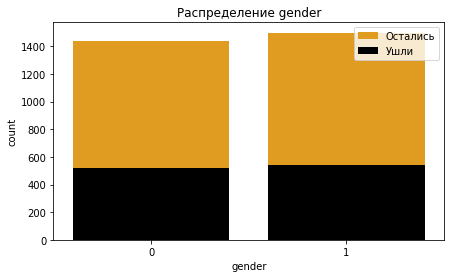

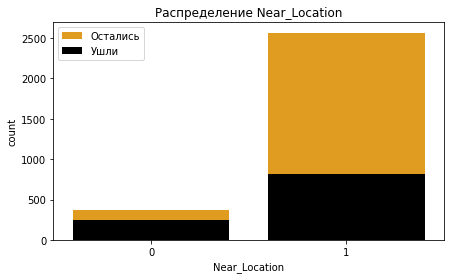

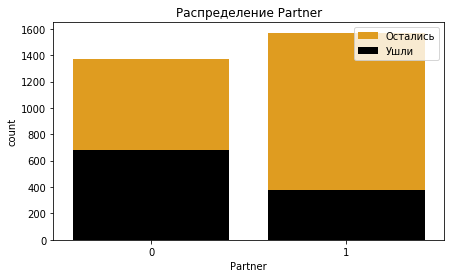

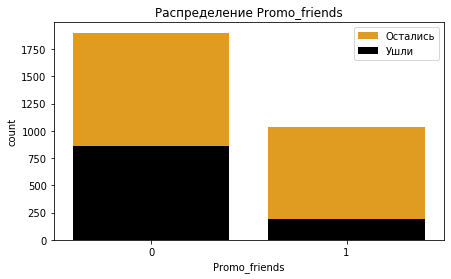

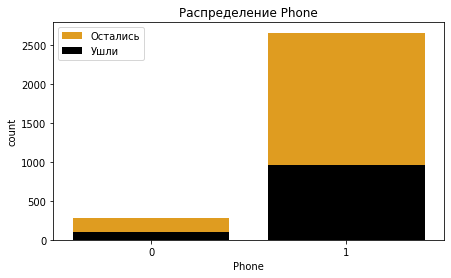

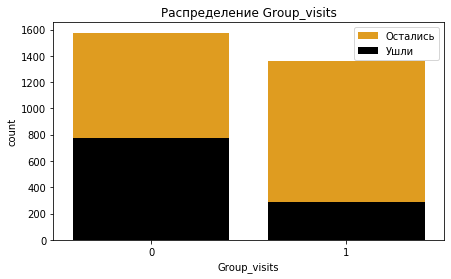

In [11]:
columns_count = ['gender','Near_Location', 'Partner', 'Promo_friends',
               'Phone', 'Group_visits']

for col in columns_count:
    
    plt.figure(figsize=(7,4))
    ax = sns.countplot(remained[col], color = 'orange', label = 'Остались')
    ax = sns.countplot(x = outflow[col], color = 'black', label = 'Ушли')
    plt.title(f"Распределение {col}")
    plt.legend()
    plt.show()


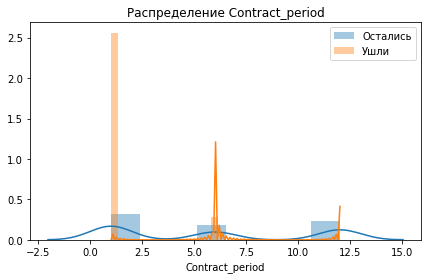

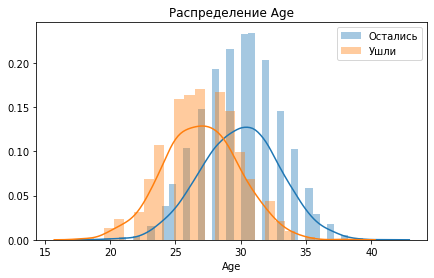

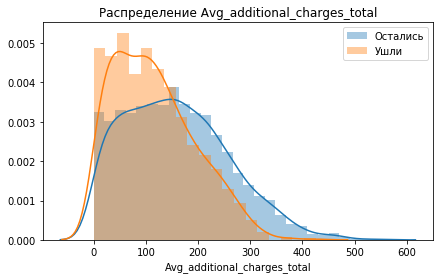

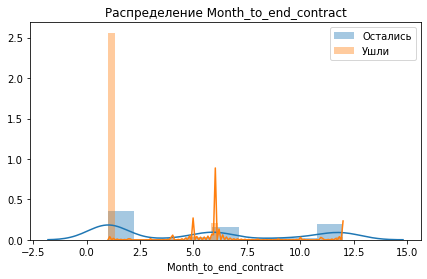

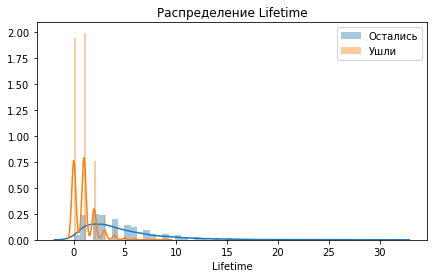

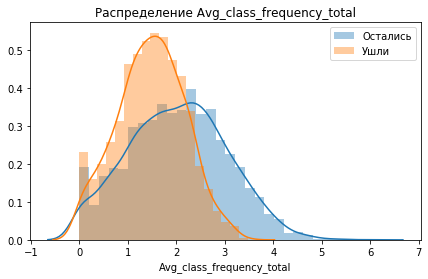

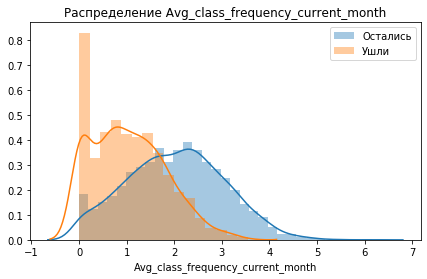

In [12]:
columns_dist = ['Contract_period','Age', 'Avg_additional_charges_total', 'Month_to_end_contract',
               'Lifetime', 'Avg_class_frequency_total', 'Avg_class_frequency_current_month']
for col in columns_dist:
    
    plt.figure(figsize=(7,4))
    ax = sns.distplot(remained[col])
    ax = sns.distplot(outflow[col])
    plt.title(f"Распределение {col}")
    plt.legend(labels = ['Остались', 'Ушли'])
    plt.show()



<h5>Из данных мы узнаем:</h5><br>
    - пол и расстояние до работы/ места жительства не влияет на вероятностьт уйти/остаться;<br>
    - клиенты, пришедшие от компаний-парнеров остаются чаще, чем пришедшие просто <br>
    - оставленный номер телефона не влияет на вероятность остаться<br>
    - те, кто берет абонемент на месяц , вероятнее всего, уйдут. И наоборот, у кого длительный абонемент, вероятнее всего, останутся<br>
    - те, кто ходил на групповые занятия, остаются чаще (отдельная категория, на которую следует обратить внимание)<br>
    - молодые уходят чаще, чем более зрелые клиенты. Вполне вероятно, что молодые люди еще не нашли свой вид физической активности и много экспериментируют<br>
    - те, кто уходят, первоначально тратят больше, тем те, кто остается<br>
    - больше всего "отваливается" клиентов на первых трех месяцах <br>
    - те, кто ходит 1-2 раза в неделю, уходят чаще. Чеи больше раз в неделю клиент посещает центр, тем больше вероятность, что он останется<br>
    - и в целом, оставшихся меньше, чем ушедших. 

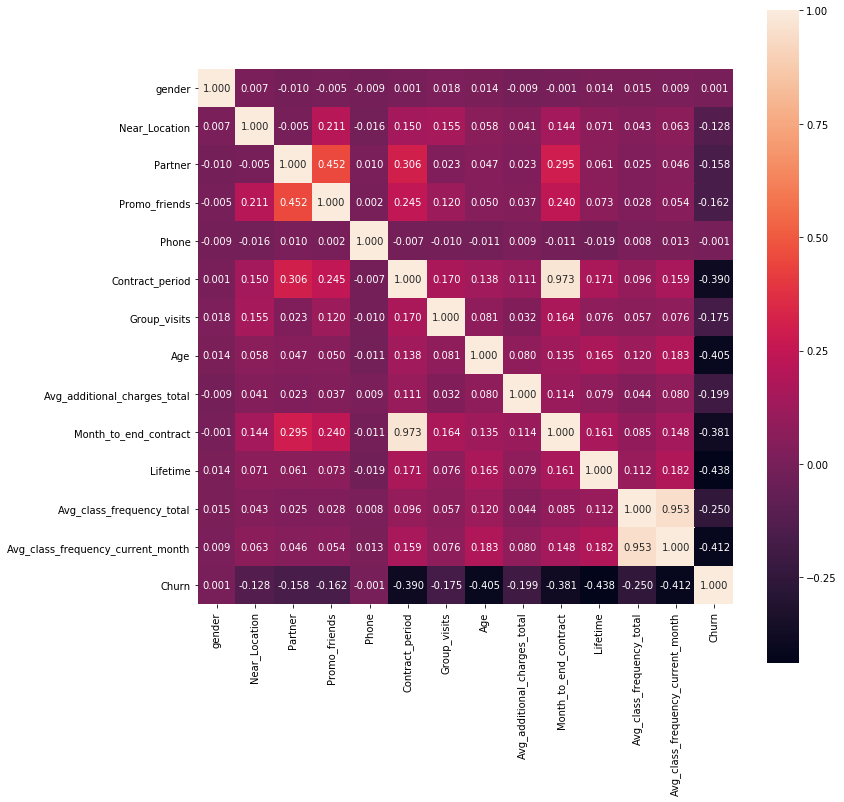

In [13]:
cm = gym.corr()
plt.figure(figsize=(12, 12))
sns.heatmap(cm, annot=True, fmt = '.3f', square=True)
plt.show()


Наиболее скоррелированы между собой срок действия абонемента и срок его окончания и количество посещений в предыдущий месяц и среднее количество посещений. Выделяется зависимость между клиентами-партерами и приглашением друзей. Возможно коллеги любят ходить вместе после работы на групповые занятия?

### 2. Модель бинарной классификации клиентов<br>

Сравним между собой модели LogisticRegression и RandomForestClassifier

In [14]:
x = gym.drop(columns=("Churn"))
y = gym["Churn"]
scaler = StandardScaler()
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0, stratify = y)


In [15]:
def predict (y_test, predictions, probabilities):
    print(f"Доля правильных ответов {(accuracy_score(y_test, predictions)).round(2)}")
    print(f"Точность {(precision_score (y_test, predictions)).round(2)}")
    print(f"Полнота {(recall_score(y_test, predictions)).round(2)}")
    print(f"F1-мера {(f1_score(y_test, predictions)).round(2)}")
    print(f"AUC-ROC {(roc_auc_score(y_test, probabilities)).round(2)}")
    

In [16]:
model = LogisticRegression(solver='liblinear', random_state = 0)
model.fit(x_train, y_train)
predictions = model.predict(x_test)
probabilities = model.predict_proba(x_test)[:,1]

print("model LogisticRegression")
predict(y_test, predictions, probabilities)

model LogisticRegression
Доля правильных ответов 0.93
Точность 0.89
Полнота 0.84
F1-мера 0.87
AUC-ROC 0.98


In [17]:
model = RandomForestClassifier(n_estimators = 100, random_state = 0)
model.fit(x_train, y_train)
predictions = model.predict(x_test)
probabilities = model.predict_proba(x_test)[:,1]

print("model RandomForestClassifier")
predict(y_test, predictions, probabilities)

model RandomForestClassifier
Доля правильных ответов 0.92
Точность 0.88
Полнота 0.83
F1-мера 0.85
AUC-ROC 0.97


 
Модели LogisticRegression и RandomForestClassifier показали хорошие результаты. Модель LogisticRegression показала лучше результат по метрикам точность, полнота и F1-мера. <br><br>
    
Так как у нас есть сильно коррелирующие признаки, удалим их и отсортируем признаки по важности. Так как модель логической регрессии показала лучшие результаты, строить таблицу важности признаков будем для нее.

In [18]:
gym = gym.drop(columns=(['Avg_class_frequency_current_month', 'Month_to_end_contract']))

In [19]:
x = gym.drop(columns=('Churn'))
y = gym['Churn']
scaler = StandardScaler()
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)


model = LogisticRegression(solver='liblinear', random_state = 0)
model.fit(x_train, y_train)
predictions = model.predict(x_test)


importance = pd.DataFrame(data={'feature': x_test.columns,
                               'importance': model.coef_[0]})
importance = importance.sort_values(by='importance', ascending=False)
importance

,feature,importance
0,gender,0.154482
4,Phone,0.075997
1,Near_Location,0.007011
2,Partner,-0.002670
8,Avg_additional_charges_total,-0.004908
7,Age,-0.200437
5,Contract_period,-0.266428
3,Promo_friends,-0.458202
10,Avg_class_frequency_total,-0.613667
6,Group_visits,-0.640821



Мы наблюдаем обратную зависимость от "времени жизни" клиента, посещения групповых занятий, среднего посещения зала в неделю и прихода по акции "приведи друга". 

### 3. Кластеризация клиентов <br>

Нарисуем дендограмму

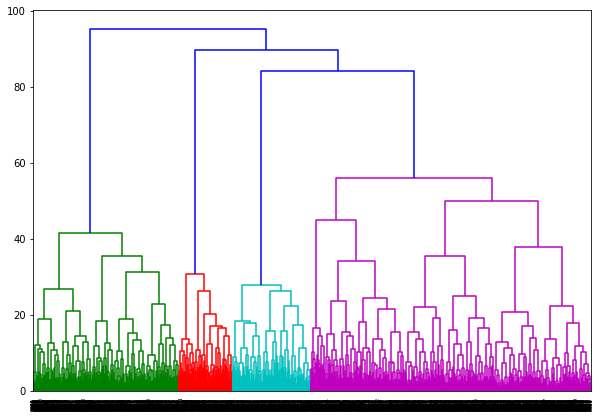

In [20]:
sc = StandardScaler()
x_sc = sc.fit_transform(x)

linked = linkage(x_scv, method = 'ward')

plt.figure(figsize=(10, 7))  
dendrogram(linked, orientation='top')
plt.show() 


На дендрограмме мы увидели 4 класса
    

In [21]:
sc = StandardScaler()
x_sc = sc.fit_transform(x)

km = KMeans(n_clusters = 5, random_state = 0) 
labels = km.fit_predict(x_sc)

df_cluster = gym
df_cluster['cluster_km'] = labels

df_cluster_gr = df_cluster.groupby('cluster_km').mean()

In [22]:
df_cluster_gr

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Lifetime,Avg_class_frequency_total,Churn
cluster_km,,,,,,,,,,,,
0,0.499109,0.000000,0.488414,0.076649,1.0,3.032086,0.235294,28.721925,137.540009,3.060606,1.770413,0.399287
1,0.488571,0.995238,0.955238,0.892381,1.0,7.660952,0.458095,29.543810,155.861428,4.380952,1.978963,0.120952
2,0.505300,1.000000,0.238516,0.059187,1.0,2.819788,0.000000,28.770318,143.383993,3.343640,1.800647,0.381625
3,0.544202,1.000000,0.250287,0.079219,1.0,4.528129,1.000000,29.536165,148.088897,3.761194,1.941342,0.200918
4,0.523316,0.862694,0.471503,0.305699,0.0,4.777202,0.427461,29.297927,144.208179,3.940415,1.854211,0.266839



Мы наблюдаем два ниаболее устойчивых класса: 1 и 3, и два наименее устойчивых - 0 и 2. <br>
Дадим характеристику среднему представителю каждого класса.<br>
    <h6>0 класстер (40% оттока) - </h6>, живут/работают в одном районе с фитнес-центром, посещающие центр около 3 мес, около 2 раз в неделю (меньше остальных групп). Возраст - 28,7 лет. Половина пришла от компаний-партнеров, покупают абонемент на три месяца, предпочитают индивидуальные занятия, тратят на доп услуги меньше остальных групп - около 138 у е.  <br>
    <h6>1 кластер (12% оттока)</h6> - пришли 4-5 мес назад от компаний-партнеров по акции приведи друга. Возраст - 29,5 лет, абонемент приобрели более чем на полгода. Тратят больше всех - около 155 у е - наиболее лояльная группа. Ходят чаще всех: 2 раза в неделю. Почти половина предпочитает групповые занятия. <br>
    <h6>2 кластер (38% оттока)</h6> - 28,7 лет, абонемент приобрели на 2-3 месяца, ходят только на индивидуальные занятия 1-2 раза в неделю. Тратят 143 у е. Вероятно, это клиенты, нацеленные на результат, для них важен тренер и комфортная коммуникация с ним.<br>
    <h6>3 кластер (20 % оттока)</h6> 29,5 лет, посещают только групповые занятия, ходят 1-2 раза в неделю, абонемент приобретают на 4-5 месяца. Тратят около 148 у е.   <br>
    <h6>4 кластер (27 % оттока)</h6> - средний возраст 29 лет. Почти половина пришла от компании-партнера 30% - по акции "приведи друга", абонемент берут 4-6 месяца, почти половина ходит на групповые занятия. В среднем, ходят 1-2 раза в неделю.  <br>
    

In [28]:
col_bar = ['Contract_period', 'Promo_friends', 'Group_visits', 'Near_Location',
          'Age', 'Avg_class_frequency_total', 'Lifetime', 'Avg_additional_charges_total']

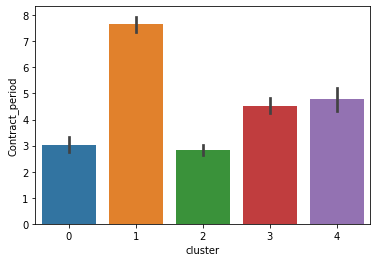

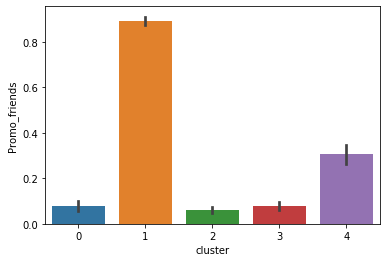

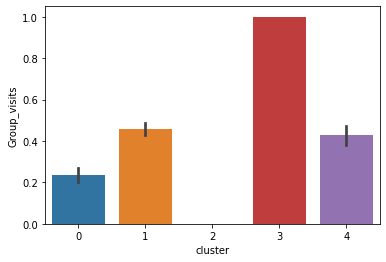

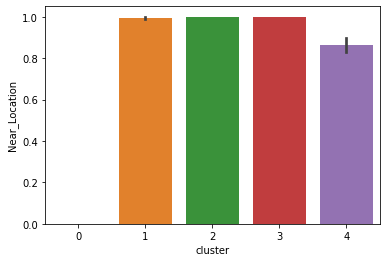

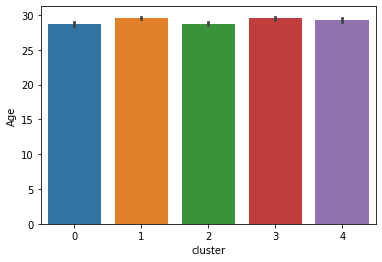

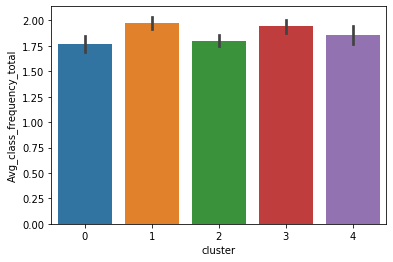

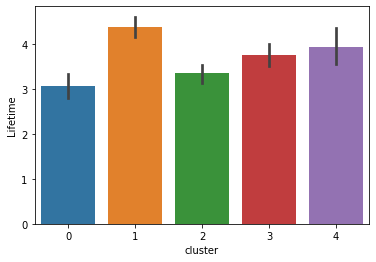

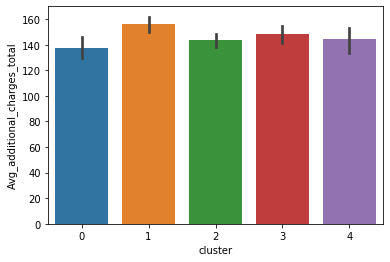

In [27]:
for col in col_bar:
    sns.barplot(x = df_cluster['cluster_km'],
                y = df_cluster[col])
    plt.xlabel('cluster')
    plt.show()


    - На дительное время абонементы покупают представители кластера 1. Самые нестабильные кластера - 0 и 2 покупают абонементы на 3 мес.<br>
    - По акции "приведи друга" наибольшее количество пользователей пришло в 1 кластере. <br>
    - Групповые занятия предпочитают представители 3 кластера.<br>
    - Только представители 0 кластера живут/работают в одном районе с фитнес-центром.<br>
    - В целом, средний возраст посетителей фитнес-центра - 30 лет. Средние траты лежат в районе 140 у е. 

### Выводы <br>

Следует сразу оговорить, что принятые дейсвия для уменьшения оттока клиентов будут зависеть, в большей степени, от ценовой категории зала и его статуса. Если это обычный зал в спальном районе, то ваше конкурентное преимущество - цена и расположение. Если это современный фитнес-центр (наличие компаний-парнеров говорит в пользу этого варианта), то целевая аудитория - состоятельные клиенты, готовые тратится на доп услуги и ценящие комфорт в виде бесплатных полотенец, воды и проч. <br>
    1. Постоянные клиенты не склонны к оттоку, приобретают абонементы на длительное время, наиболее лояльны к фитнес-центру, поэтому тратят на доп услуги больше всех. Для них можно ввести комбинированные абонементы на длительное время:например, абонемент на 6 месяцев с возможностью посещать раз в неделю сауну или занятие по растяжке. Или же, учитывая средний возраст, ввести семейные абонементы: для двух взрослых со скидкой, абонемент в бассейн для всей семьи или возможность посещать зал с ребенком, для которого оборудована игровая зона с воспитателем (молодые мамы с детьми, которые желают привести себя в форму, оценят). Таким образом можно увеличить доход и поднять свой имидж. <br>
    2. Следует также проанализировать причины ухода клиентов, которые живут/работают в одно районе с залом. Возможно, дело в открывшемся рядом центре, который переманил скидками часть клиентов. <br>
    3. В мире фитнеса есть также мода на виды занятий у разных групп клиентов. Необходимо проанализировать популярные виды активности в самых мало представленных сегментах: 18-25 лет и 50+. В США залы активно взаимодействуют со старшими поколениями, так как среди них достаточно обеспеченных людей, которые хотят социальной жизни + старшее поколение менее подвержено оттоку. Также не стоит забывать о моде на "активную и красивую старость", связанную с появлением возрастных моделей в соц сетях. <br>
    4. Стоит также расширять свою сеть компаний-партеров, продвигать акцию "приведи друга" - люди больше доверяют своим знакомым, да и ходить в компании на фитнес веселее. Возможно, стоит обратить свое внимание на частные медицинские центры и предложить застрахованным там клиентам абонементы со скидкой. <br>
    